# International Geomagnetic Reference Field (IGRF) model

The present notebook evaluates the the IGRF model (Alken et al., 2021), available at [NOAA/NCEI](https://www.ncei.noaa.gov/products/international-geomagnetic-reference-field), but developed and maintained by the [International Association of Geomagnetism and Aeronomy (IAGA)](https://www.iaga-aiga.org/). The results presented here are produced with the 14th Generation IGRF coefficients computed by the participating members of [IAGA Working Group V-MOD](https://www.ncei.noaa.gov/services/world-data-system/v-mod-working-group). The required python routines at `_pyIGRF.py` and `_igrf_utils.py` are based on those developed by Ciaran Beggan (British Geological Survey), available at [NOAA/NCEI](https://www.ncei.noaa.gov/products/international-geomagnetic-reference-field).

* Alken, P., Thébault, E., Beggan, C.D. et al. (2021) International Geomagnetic Reference Field: the thirteenth generation. Earth Planets Space 73, 49, doi:[10.1186/s40623-020-01288-x](https://doi.org/10.1186/s40623-020-01288-x)

## Import required packages and define auxiliary functions

In [1]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import geopandas as gpd

In [3]:
from coordinates import transform, geodetic_elipsoids, utils
from _pyIGRF import pyIGRF
import _igrf_utils as iut

In [4]:
import gc

In [5]:
def date_decimal_year(date):
    """
    Auxiliary function to convert datetime (https://docs.python.org/3/library/datetime.html) 
    to decimal year.
    """
    date0 = dt.datetime(date.year, 1, 1)
    time_delta = date - date0
    date_dy = date.year + time_delta.days / 365 + time_delta.seconds / (24 * 3600 * 365.25)
    return date_dy

## Load shapefiles of brazilian states

In [6]:
br_states = gpd.read_file("estados_Brasil/BRA_adm1.shp")

In [7]:
br_states.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Set the computation points in the Geocentric Geodetic System (GGS)

In [8]:
# Reference point at the study area
height0 = 100 # in meters
longitude0 = -51.62 # in degrees
latitude0 = -15.8 # in degrees

In [9]:
delta_longitude = 3. # in degrees
delta_latitude = 3. # in degrees

longitude = np.linspace(
    longitude0-delta_longitude, 
    longitude0+delta_longitude, 
    101
)
latitude = np.linspace(
    latitude0-delta_latitude, 
    latitude0+delta_latitude, 
    101
)
longitude, latitude = np.meshgrid(longitude, latitude)
longitude = longitude.ravel()
latitude = latitude.ravel()
height = np.zeros_like(longitude) + height0

In [10]:
# Create a python dictionary to store the data
data = {
    'longitude' : longitude,
    'latitude' : latitude,
    'height' : height
}

data = pd.DataFrame(data)

In [11]:
data

,longitude,latitude,height
0,-54.62,-18.8,100.0
1,-54.56,-18.8,100.0
2,-54.50,-18.8,100.0
3,-54.44,-18.8,100.0
4,-54.38,-18.8,100.0
...,...,...,...
10196,-48.86,-12.8,100.0
10197,-48.80,-12.8,100.0
10198,-48.74,-12.8,100.0
10199,-48.68,-12.8,100.0


In [12]:
del longitude, latitude, height
gc.collect()

0

## Set the dates

In [13]:
# Set the date and hour when the IGRF will be evaluated
# I have chosen 10/Mar/2022, at 12:30
date = data.shape[0]*[dt.datetime(2022, 3, 10, 12, 30),]

In [14]:
data['datetime'] = date

In [15]:
data

,longitude,latitude,height,datetime
0,-54.62,-18.8,100.0,2022-03-10 12:30:00
1,-54.56,-18.8,100.0,2022-03-10 12:30:00
2,-54.50,-18.8,100.0,2022-03-10 12:30:00
3,-54.44,-18.8,100.0,2022-03-10 12:30:00
4,-54.38,-18.8,100.0,2022-03-10 12:30:00
...,...,...,...,...
10196,-48.86,-12.8,100.0,2022-03-10 12:30:00
10197,-48.80,-12.8,100.0,2022-03-10 12:30:00
10198,-48.74,-12.8,100.0,2022-03-10 12:30:00
10199,-48.68,-12.8,100.0,2022-03-10 12:30:00


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10201 entries, 0 to 10200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   longitude  10201 non-null  float64       
 1   latitude   10201 non-null  float64       
 2   height     10201 non-null  float64       
 3   datetime   10201 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3)
memory usage: 318.9 KB


In [17]:
del date
gc.collect()

0

In [18]:
# Convert datetime to decimal years
data['datetime'] = data['datetime'].apply(date_decimal_year)

In [19]:
data

,longitude,latitude,height,datetime
0,-54.62,-18.8,100.0,2022.187727
1,-54.56,-18.8,100.0,2022.187727
2,-54.50,-18.8,100.0,2022.187727
3,-54.44,-18.8,100.0,2022.187727
4,-54.38,-18.8,100.0,2022.187727
...,...,...,...,...
10196,-48.86,-12.8,100.0,2022.187727
10197,-48.80,-12.8,100.0,2022.187727
10198,-48.74,-12.8,100.0,2022.187727
10199,-48.68,-12.8,100.0,2022.187727


## Evaluate the IGRF in the GGS and TCS systems

In [20]:
northward_GGS, eastward_GGS, inward_GGS  = pyIGRF(
    data['longitude'].values, 
    data['latitude'].values, 
    data['height'].values, 
    data['datetime'].values
)

100%|████████████████████████████████████| 10201/10201 [00:12<00:00, 809.86it/s]


In [21]:
data['northward GGS'] = northward_GGS
data['eastward GGS'] = eastward_GGS
data['inward GGS'] = inward_GGS

In [22]:
del northward_GGS, eastward_GGS, inward_GGS
gc.collect()

0

In [23]:
northward_TCS, eastward_TCS, inward_TCS = iut.igrf_GGS2TCS(
    data['longitude'].values, 
    data['latitude'].values, 
    data['height'].values, 
    data['northward GGS'].values, 
    data['eastward GGS'].values,
    data['inward GGS'].values, 
    longitude0, latitude0, height0
)

In [24]:
data['northward TCS'] = northward_TCS
data['eastward TCS'] = eastward_TCS
data['inward TCS'] = inward_TCS

In [25]:
del northward_TCS, eastward_TCS, inward_TCS
gc.collect()

0

In [26]:
data

,longitude,latitude,height,datetime,northward GGS,eastward GGS,inward GGS,northward TCS,eastward TCS,inward TCS
0,-54.62,-18.8,100.0,2022.187727,19248.881167,-6447.804504,-10120.697146,18595.053553,-7265.038983,-10768.719133
1,-54.56,-18.8,100.0,2022.187727,19237.541740,-6457.080632,-10142.370132,18584.528988,-7259.010857,-10796.602153
2,-54.50,-18.8,100.0,2022.187727,19226.201226,-6466.305247,-10164.064257,18574.004094,-7252.890038,-10824.512801
3,-54.44,-18.8,100.0,2022.187727,19214.859662,-6475.478350,-10185.779273,18563.478859,-7246.676428,-10852.450623
4,-54.38,-18.8,100.0,2022.187727,19203.517087,-6484.599942,-10207.514936,18552.953273,-7240.369935,-10880.415162
...,...,...,...,...,...,...,...,...,...,...
10196,-48.86,-12.8,100.0,2022.187727,20263.188042,-7971.877652,-9632.460952,20839.676413,-7294.160139,-8912.633830
10197,-48.80,-12.8,100.0,2022.187727,20253.554478,-7975.982239,-9659.629643,20833.602568,-7282.134623,-8947.777707
10198,-48.74,-12.8,100.0,2022.187727,20243.922596,-7980.035392,-9686.800038,20827.527177,-7269.998271,-8982.911484
10199,-48.68,-12.8,100.0,2022.187727,20234.292453,-7984.037175,-9713.971912,20821.450219,-7257.751166,-9018.034696


In [27]:
F_GGS = np.sqrt(
    data['northward GGS'].values**2 + 
    data['eastward GGS'].values**2 + 
    data['inward GGS'].values**2
)

In [28]:
F_TCS = np.sqrt(
    data['northward TCS'].values**2 + 
    data['eastward TCS'].values**2 + 
    data['inward TCS'].values**2
)

In [29]:
# The magnitude is invariante under rotation of coordinate system
np.allclose(F_TCS, F_GGS)

True

In [30]:
data['intensity'] = F_GGS

In [31]:
del F_GGS, F_TCS
gc.collect()

0

In [32]:
dec_GGS, inc_GGS = iut.compute_declination_inclination(
    data['northward GGS'].values,
    data['eastward GGS'].values,
    data['inward GGS'].values
)

In [33]:
dec_TCS, inc_TCS = iut.compute_declination_inclination(
    data['northward TCS'].values,
    data['eastward TCS'].values,
    data['inward TCS'].values
)

In [34]:
data['declination GGS'] = dec_GGS
data['inclination GGS'] = inc_GGS
data['declination TCS'] = dec_TCS
data['inclination TCS'] = inc_TCS

In [35]:
del dec_GGS, inc_GGS, dec_TCS, inc_TCS
gc.collect()

0

In [36]:
data

,longitude,latitude,height,datetime,northward GGS,eastward GGS,inward GGS,northward TCS,eastward TCS,inward TCS,intensity,declination GGS,inclination GGS,declination TCS,inclination TCS
0,-54.62,-18.8,100.0,2022.187727,19248.881167,-6447.804504,-10120.697146,18595.053553,-7265.038983,-10768.719133,22683.080034,-18.519322,-26.498748,-21.340458,-28.342864
1,-54.56,-18.8,100.0,2022.187727,19237.541740,-6457.080632,-10142.370132,18584.528988,-7259.010857,-10796.602153,22685.779122,-18.554327,-26.556527,-21.335333,-28.419228
2,-54.50,-18.8,100.0,2022.187727,19226.201226,-6466.305247,-10164.064257,18574.004094,-7252.890038,-10824.512801,22688.501920,-18.589221,-26.614352,-21.329953,-28.495676
3,-54.44,-18.8,100.0,2022.187727,19214.859662,-6475.478350,-10185.779273,18563.478859,-7246.676428,-10852.450623,22691.248338,-18.624006,-26.672221,-21.324319,-28.572207
4,-54.38,-18.8,100.0,2022.187727,19203.517087,-6484.599942,-10207.514936,18552.953273,-7240.369935,-10880.415162,22694.018288,-18.658680,-26.730133,-21.318430,-28.648820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10196,-48.86,-12.8,100.0,2022.187727,20263.188042,-7971.877652,-9632.460952,20839.676413,-7294.160139,-8912.633830,23810.332357,-21.475507,-23.862907,-19.290716,-21.982162
10197,-48.80,-12.8,100.0,2022.187727,20253.554478,-7975.982239,-9659.629643,20833.602568,-7282.134623,-8947.777707,23814.516718,-21.494845,-23.929947,-19.266458,-22.069307
10198,-48.74,-12.8,100.0,2022.187727,20243.922596,-7980.035392,-9686.800038,20827.527177,-7269.998271,-8982.911484,23818.720828,-21.514068,-23.996981,-19.241909,-22.156430
10199,-48.68,-12.8,100.0,2022.187727,20234.292453,-7984.037175,-9713.971912,20821.450219,-7257.751166,-9018.034696,23822.944633,-21.533176,-24.064009,-19.217067,-22.243529


## Plot the results

In [37]:
min_dec = np.min([
    data['declination GGS'].min(axis=0), data['declination TCS'].min(axis=0)
])
max_dec = np.max([
    data['declination GGS'].max(axis=0), data['declination TCS'].max(axis=0)
])

min_inc = np.min([
    data['inclination GGS'].min(axis=0), data['inclination TCS'].min(axis=0)
])
max_inc = np.max([
    data['inclination GGS'].max(axis=0), data['inclination TCS'].max(axis=0)
])

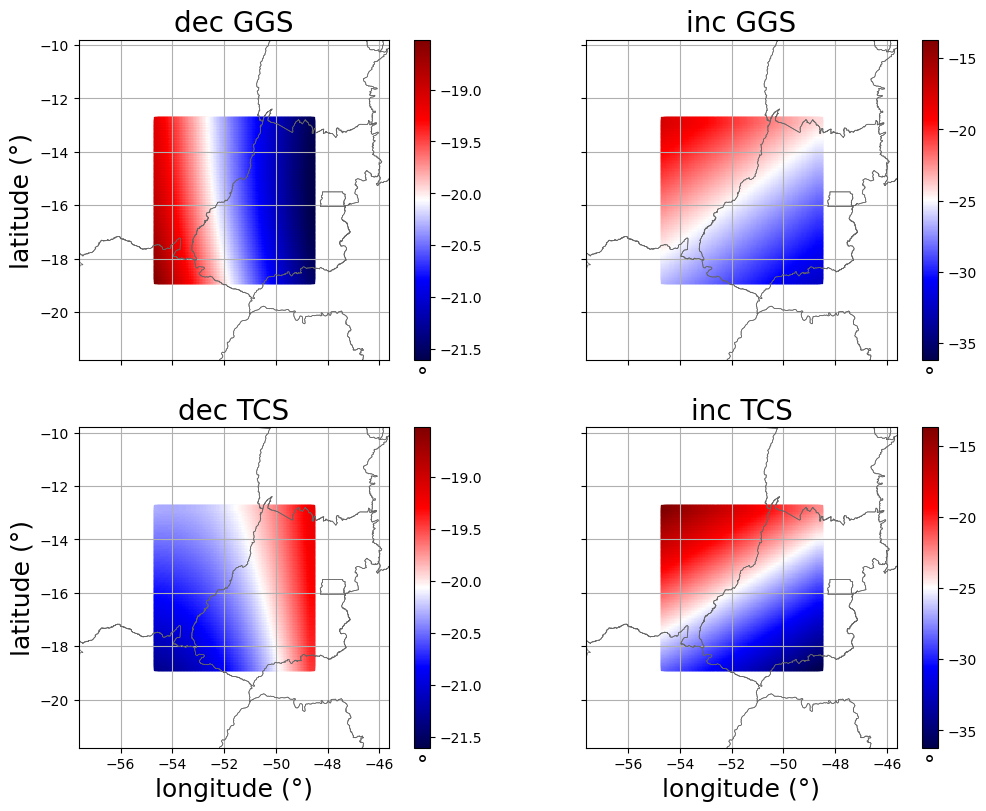

In [38]:
expand_borders = 3
fig = plt.figure(layout= 'constrained', figsize=(10,8))
mosaic = fig.subplot_mosaic(
    mosaic= '''
            ab
            cd
            ''',
    sharey=True, sharex=True
)
for (element, field, name, ranges) in zip(
    ['a', 'b', 'c', 'd'], 
    [
        data['declination GGS'], data['inclination GGS'], 
        data['declination TCS'], data['inclination TCS']
    ],
    ['dec GGS', 'inc GGS', 'dec TCS', 'inc TCS'], 
    [
        [min_dec, max_dec],
        [min_inc, max_inc],
        [min_dec, max_dec],
        [min_inc, max_inc]
    ]
):

    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.scatter(
        x=data['longitude'], y=data['latitude'], c=field, s=14, marker='s',
        cmap='seismic', vmin=ranges[0], vmax=ranges[1]
    )
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=10)
    cb.ax.set_xlabel('°', fontsize=16, loc='center')
    
    # Plot brazilian states
    br_states.boundary.plot(ax=ax, color=3*(0.4,), lw=0.5)
    
    ax.set_ylim(
        data['latitude'].min(axis=0)-expand_borders, 
        data['latitude'].max(axis=0)+expand_borders
    )
    ax.set_xlim(
        data['longitude'].min(axis=0)-expand_borders, 
        data['longitude'].max(axis=0)+expand_borders
    )
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid()
    ax.set_title(name, fontsize=20)

for element in ['a', 'c']:
    mosaic[element].set_ylabel('latitude (°)', fontsize=18)

for element in ['c','d']:
    mosaic[element].set_xlabel('longitude (°)', fontsize=18)

plt.show()

In [39]:
min_dec_diff = np.min(data['declination TCS'].values - data['declination GGS'].values)
max_dec_diff = np.max(data['declination TCS'].values - data['declination GGS'].values)

min_inc_diff = np.min(data['inclination TCS'].values - data['inclination GGS'].values)
max_inc_diff = np.max(data['inclination TCS'].values - data['inclination GGS'].values)

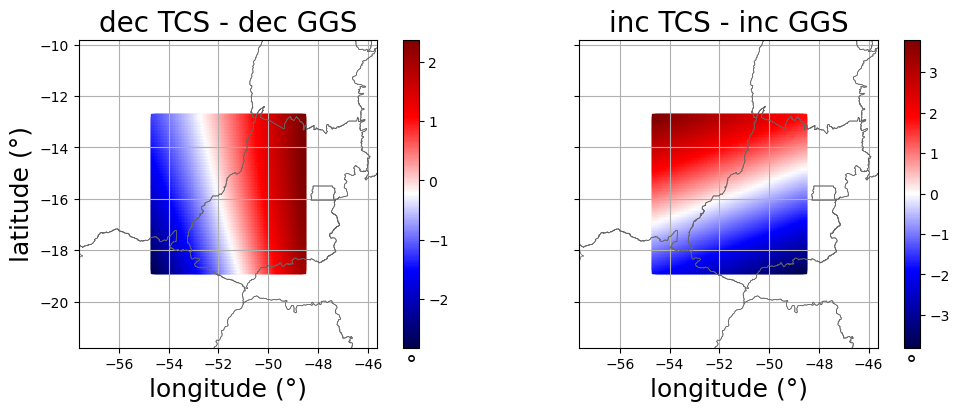

In [40]:
expand_borders = 3
fig = plt.figure(layout= 'constrained', figsize=(10,4))
mosaic = fig.subplot_mosaic(
    mosaic= '''
            ab
            ''',
    sharey=True, sharex=True
)
for (element, field, name, ranges) in zip(
    ['a', 'b'], 
    [
        data['declination TCS'].values - data['declination GGS'].values, 
        data['inclination TCS'].values - data['inclination GGS'].values
    ], 
    ['dec TCS - dec GGS', 'inc TCS - inc GGS'], 
    [
        [min_dec_diff, max_dec_diff],
        [min_inc_diff, max_inc_diff]
    ]
):

    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.scatter(
        x=data['longitude'], y=data['latitude'], c=field, s=14, marker='s',
        cmap='seismic', vmin=ranges[0], vmax=ranges[1]
    )
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=10)
    cb.ax.set_xlabel('°', fontsize=16, loc='center')
    
    # Plot brazilian states
    br_states.boundary.plot(ax=ax, color=3*(0.4,), lw=0.5)
    
    ax.set_ylim(
        data['latitude'].min(axis=0)-expand_borders, 
        data['latitude'].max(axis=0)+expand_borders
    )
    ax.set_xlim(
        data['longitude'].min(axis=0)-expand_borders, 
        data['longitude'].max(axis=0)+expand_borders
    )
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid()
    ax.set_title(name, fontsize=20)

for element in ['a']:
    mosaic[element].set_ylabel('latitude (°)', fontsize=18)

for element in ['a','b']:
    mosaic[element].set_xlabel('longitude (°)', fontsize=18)

plt.show()